为了让每部分实验更加独立，故将初始化、正则化、梯度校验三部分进行划分独立

### 软件包

In [22]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io as sio

## 初始化 init_utils

In [21]:
# 用类的方法来写
class init_utils:
    def __init__(self, learning_rate=0.01):
        self.parameters = {}
        self.learning_rate = learning_rate

    # 计算 sigmoid 激活函数
    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -500, 500) # 防止溢出，避免计算出现 inf 或 nan
        s = 1 / (1 + np.exp(-z))
        return s

    # 计算 relu 激活函数
    @staticmethod
    def relu(z):
        s = np.maximum(0, z) # np.maximum() 逐元素比较 0 和 z 中的每个元素，返回它们中较大的那个。
        return s

    # 计算交叉熵损失
    @staticmethod
    def comput_loss(Y_hat, Y): # Y_hat: 预测值(模型最后一层的输出)，Y: 真实值
        m = Y.shape[1]
        logprobs = np.multiply(-np.log(Y_hat), Y) + np.multiply(-np.log(1 - Y_hat), 1 - Y)
        loss = 1. / m * np.sum(logprobs)
        return loss

    # 实现三层神经网络的前向传播流程
    def forward_propagation(self, X):
        W1, b1 = self.parameters['W1'], self.parameters['b1']
        W2, b2 = self.parameters['W2'], self.parameters['b2']
        W3, b3 = self.parameters['W3'], self.parameters['b3']

        z1 = np.dot(W1, X) + b1
        a1 = self.relu(z1)
        z2 = np.dot(W2, a1) + b2
        a2 = self.relu(z2)
        z3 = np.dot(W3, a2) + b3
        a3 = self.sigmoid(z3)

        cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
        return a3, cache

    # 实现三层神经网络的反向传播流程
    @staticmethod
    def backward_propagation(X, Y, cache):
        (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
        m = X.shape[1]
        dz3 = a3 - Y
        dW3 = np.dot(dz3, a2.T)
        db3 = np.sum(dz3, axis=1, keepdims=True)

        da2 = np.dot(W3.T, dz3)
        dz2 = np.multiply(da2, np.int64(a2 > 0))
        dW2 = np.dot(dz2, a1.T)
        db2 = np.sum(dz2, axis=1, keepdims=True)

        da1 = np.dot(W2.T, dz2)
        dz1 = np.multiply(da1, np.int64(a1 > 0))
        dW1 = np.dot(dz1, X.T)
        db1 = np.sum(dz1, axis=1, keepdims=True)

        gradients = {
            "dZ3": dz3, "dW3": dW3, "db3": db3,
            "da2": da2, "dZ2": dz2, "dW2": dW2, "db2": db2,
            "da1": da1, "dZ1": dz1, "dW1": dW1, "db1": db1
        }

        return gradients

    # 参数更新（梯度下降）
    def update_parameters(self, gradients, learning_rate):
        L = len(self.parameters) // 2
        for l in range(L):
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]

    # 进行预测并计算准确率
    def predict(self, X, y):
        m = X.shape[1]
        p = np.zeros((1, m), dtype=np.int)

        # 前向传播
        Y_hat, caches = self.forward_propagation(X)

        # 第一种写法
        for i in range(Y_hat.shape[1]):
            if Y_hat[0, i] > 0.5:
                p[0, i] = 1
            else:
                p[0, i] = 0

        # 打印预测结果
        print("Accuracy: " + str(np.mean((p[0, :] == y[0, :]))))

        return p

        # 第二种写法
        # p[0, :] = (Y_hat > 0.5).astype(int)
        # print("Accuracy:", np.mean(p == y))
        # return p

    # 生成一个带噪声的“圆形”数据集, 这是一个二分类任务，用于验证神经网络的非线性分类能力
    @staticmethod
    def load_dataset(is_plot=True):
        np.random.seed(1) # 设置随机种子为 1，保证每次生成的数据集都是相同的。用于训练集
        train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
        """
        使用 sklearn 中的 make_circles 函数生成一个二分类的同心圆形数据集（即两类数据分布在两个圆上），
            train_X：维度是 (300, 2)，即 300 个样本，每个样本是二维点 (x1, x2)
            train_Y：维度是 (300,)，每个样本的标签（0 或 1）
        """
        np.random.seed(2) # 重新设置随机种子为 2，以生成 不同于训练集 的测试集。
        test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)

        # 是否需要绘制
        if is_plot:
            plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral)

        train_X = train_X.T
        train_Y = train_Y.reshape((1, train_Y.shape[0]))
        test_X = test_X.T
        test_Y = test_Y.reshape((1, test_Y.shape[0]))

        return train_X, train_Y, test_X, test_Y

    # 可视化分类边界
    @staticmethod
    def plot_decision_boundary(model, X, y):
        # 设置边界
        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
        h = 0.01

        # 生成网格
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # 预测整个网格的函数值
        Z = model(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # 绘制图像
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
        plt.show()

    # 辅助绘图函数，预测每个点属于哪一类（用于画边界） 返回：0/1 的布尔数组
    def predict_dec(self, X):
        # 使用前向传播计算最终输出
        Y_hat, cache = self.forward_propagation(X.T) # 这里用了X.T
        predictions = (Y_hat > 0.5)
        return predictions

        """
            这个函数是为了配合 plot_decision_boundary() 函数使用的，它不会打印准确率，也不返回概率，而是直接将预测值进行 0/1 分类。
            在绘制决策边界时，每个网格点坐标都会作为 X 传进来，predict_dec 会判断它属于哪一类（0 或 1），从而用颜色进行区分。
        """

# init_utils.load_dataset(is_plot=True)

### 正则化 reg_utils

(array([[-1.58986e-01, -3.47926e-01, -5.04608e-01, -5.96774e-01,
         -5.18433e-01, -2.92627e-01, -1.58986e-01, -5.76037e-02,
         -7.14286e-02, -2.97235e-01, -4.17051e-01, -4.40092e-01,
         -3.24885e-01, -2.46544e-01, -2.18894e-01, -3.43318e-01,
         -5.09217e-01, -3.84793e-01, -1.49770e-01, -1.95853e-01,
         -3.91705e-02, -1.08295e-01, -1.86636e-01, -2.18894e-01,
         -8.06452e-02,  6.68203e-02,  9.44700e-02,  1.86636e-01,
          6.22120e-02,  2.07373e-02,  2.99539e-02, -9.90783e-02,
         -6.91244e-03,  1.31336e-01,  2.32719e-01,  8.52535e-02,
         -1.31336e-01,  2.30415e-03,  1.22120e-01, -3.47926e-01,
         -2.28111e-01, -7.60369e-02,  4.37788e-02,  1.15207e-02,
         -4.17051e-01, -3.15668e-01,  1.26728e-01,  2.05069e-01,
          2.18894e-01,  7.14286e-02, -1.31336e-01, -2.09677e-01,
         -2.28111e-01, -1.45161e-01, -6.68203e-02,  1.35945e-01,
          2.69585e-01,  2.97235e-01,  2.74194e-01,  2.55760e-01,
          2.23502e-01,  1

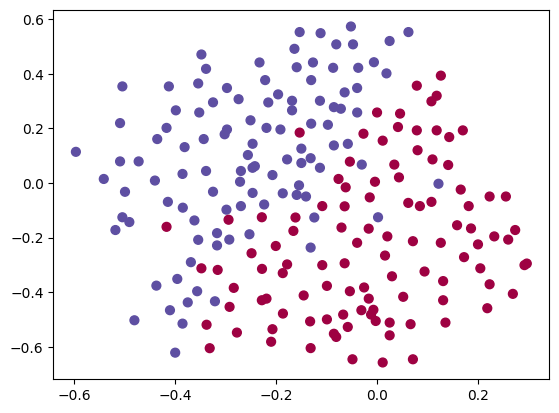

In [24]:
class reg_utils:
    def __init__(self, parameters, learning_rate=0.01, layers_dims = [2, 3, 2, 1]):
        self.learning_rate = learning_rate
        self.layers_dims = layers_dims
        self.parameters = {}

    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -500, 500)
        s = 1 / (1 + np.exp(-z))
        return s

    @staticmethod
    def relu(z):
        s = np.maximum(0, z)
        return s

    def initialize_parameters(self):
        np.random.seed(3)
        L = len(self.layers_dims) // 2

        for l in range(1, L):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_dims[l], self.layers_dims[l - 1]) / np.sqrt(self.layers_dims[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_dims[l], 1))

            # 断言
            assert(self.parameters["W" + str(l)].shape == (self.layers_dims[l], self.layers_dims[l - 1]))
            assert(self.parameters["b" + str(l)].shape == (self.layers_dims[l], 1))

        return self.parameters

    def forward_propagation(self, X):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]
        W3 = self.parameters["W3"]
        b3 = self.parameters["b3"]

        z1 = np.dot(W1, X) + b1
        a1 = self.tanh(z1)
        z2 = np.dot(W2, a1) + b2
        a2 = self.tanh(z2)
        z3 = np.dot(W3, a2) + b3
        a3 = self.sigmoid(z3)

        cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)

        return a3, cache

    @staticmethod
    def computer_cost(Y_hat, Y):
        m = Y.shape[1]
        logprobs = np.multiply(np.log(Y_hat), Y) + np.multiply(np.log(1 - Y_hat), (1 - Y))
        cost = - np.sum(logprobs) / m

        return cost

    @staticmethod
    def backward_propagation(X, Y, cache):
        (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
        m = X.shape[1]
        dz3 = a3 - Y
        dW3 = np.dot(dz3, a2.T)
        db3 = np.sum(dz3, axis=1, keepdims=True)

        da2 = np.dot(W3.T, dz3)
        dz2 = np.multiply(da2, np.int64(a2 > 0))
        dW2 = np.dot(dz2, a1.T)
        db2 = np.sum(dz2, axis=1, keepdims=True)

        da1 = np.dot(W2.T, dz2)
        dz1 = np.multiply(da1, np.int64(a1 > 0))
        dW1 = np.dot(dz1, X.T)
        db1 = np.sum(dz1, axis=1, keepdims=True)

        gradients = {
            "dZ3": dz3, "dW3": dW3, "db3": db3,
            "da2": da2, "dZ2": dz2, "dW2": dW2, "db2": db2,
            "da1": da1, "dZ1": dz1, "dW1": dW1, "db1": db1
        }

        return gradients

    def update_parameters(self, gradients, learning_rate):
        L = len(self.parameters) // 2
        for l in range(L):
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]

    # 加载数据集
    @staticmethod
    def load_2D_dataset(is_plot=False):
        data = sio.loadmat('datasets/data.mat')
        train_X = data['X'].T
        train_Y = data['y'].T
        test_X = data['Xval'].T
        test_Y = data['yval'].T
        if is_plot:
            plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral)
        return train_X, train_Y, test_X, test_Y

    def predict(self, X, y):
        m = X.shape[1]
        p = np.zeros((1, m), dtype=np.int)

        # 前向传播
        Y_hat, caches = self.forward_propagation(X)

        # 第一种写法
        for i in range(Y_hat.shape[1]):
            if Y_hat[0, i] > 0.5:
                p[0, i] = 1
            else:
                p[0, i] = 0

        # 打印预测结果
        print("Accuracy: " + str(np.mean((p[0, :] == y[0, :]))))

        return p

        # 第二种写法
        # p[0, :] = (Y_hat > 0.5).astype(int)
        # print("Accuracy:", np.mean(p == y))
        # return p

    @staticmethod
    def plot_decision_boundary(model, X, y):
        # 设置边界
        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
        h = 0.01

        # 生成网格
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # 预测整个网格的函数值
        Z = model(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # 绘制图像
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
        plt.show()

    # 辅助绘图函数，预测每个点属于哪一类（用于画边界） 返回：0/1 的布尔数组
    def predict_dec(self, X):
        # 使用前向传播计算最终输出
        Y_hat, cache = self.forward_propagation(X.T) # 这里用了X.T
        predictions = (Y_hat > 0.5)
        return predictions

# reg_utils.load_2D_dataset(is_plot=True)
